# Проект: Машинное обучение для текстов


Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.<br>Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.<br>Полученная модель должна быть со значением метрики качества F1 не меньше 0.75.

## Шаг 1. Общий обзор данных

In [1]:
import pandas as pd
import nltk
import re
from nltk.stem.snowball import EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

In [2]:
try:
    df = pd.read_csv("D:\datasets/toxic_comments.csv", sep = ',', index_col=[0]) #записываем данные из файла в переменную df
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', sep = ',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


В таблице два столбца - целевой признак toxic(является комментарий токсичным (1) или нет (0)) и столбец с текстом комментария. Дубликаты отсутствуют.

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Текст не лемматизирован и содержит лишние символы, например '\' и 'n'

In [5]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Пропусков в данных нет

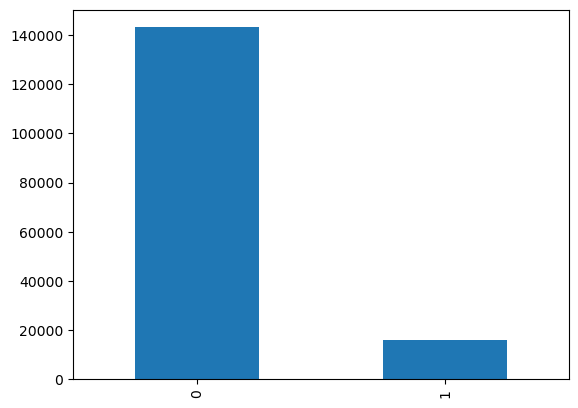

In [6]:
df['toxic'].value_counts().plot(kind='bar');

В классах целевого признака присутствует дисбаланс, токсичных комментариев намного меньше

## Шаг 2. Подготовка данных

Разделение выборок


In [7]:
# раделим таргет и признаки
target = df['toxic']
features = df['text']

Теперь разделим весь датасет на выборки - обучающую валидационную и тестовую в соотношении 3:1:1

In [8]:
features_train, features_other, target_train, target_other = train_test_split(features, target,random_state=12345, test_size=0.4, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_other, target_other,random_state=12345, test_size=0.5, stratify=target_other)

In [9]:
print('Размеры тренировочных выборок:', features_train.shape, target_train.shape)

Размеры тренировочных выборок: (95575,) (95575,)


In [10]:
print('Размеры валидационных выборок:', features_valid.shape, target_valid.shape)

Размеры валидационных выборок: (31858,) (31858,)


In [11]:
print('Размеры тестовых выборок:', features_test.shape, target_test.shape)

Размеры тестовых выборок: (31859,) (31859,)


Очистка

Очистим тексты с помощию регулярных выражений:

1. Приведем все к нижнему регистру
2. Удалим спец символы \n \r
3. Выберем только слова

In [12]:
def clean(text):
    text = text.lower()
    text = re.sub(r"(?:\n|\r)", "", text)
    text = re.sub(r"[^a-zA-Z ]+", " ", text).strip()
    return text

Лемматизация

In [13]:
stemmer = EnglishStemmer(ignore_stopwords=False)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Глеб\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
def lemmatizer(corpus):
    word_list = nltk.word_tokenize(corpus)
    return ' '.join([stemmer.stem(w) for w in word_list])

In [15]:
%%time
# очищаем и лемматизируем текст
corpus_train = features_train.apply(clean).apply(lemmatizer)
corpus_valid = features_valid.apply(clean).apply(lemmatizer)
corpus_test = features_test.apply(clean).apply(lemmatizer)

Wall time: 2min 18s


Tf-idf

In [16]:
# векторизуем данные с учетом стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
tf_idf = TfidfVectorizer(stop_words=stopwords)
corpus_train = tf_idf.fit_transform(corpus_train)
corpus_valid = tf_idf.transform(corpus_valid)
corpus_test = tf_idf.transform(corpus_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Глеб\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Шаг 3. Обучение моделей


## Логистическая регрессия

In [17]:
%%time
param = { 'C': range(1, 11, 2),
          'class_weight': [None, 'balanced'],
          'solver': ['lbfgs', 'liblinear']
          }

model_lr = LogisticRegression()

# инициализируем GridSearchCV
cv_lr = GridSearchCV(estimator = model_lr,
                     param_grid = param,
                     cv = 3,
                     n_jobs = -1,
                     verbose = 0,
                     scoring = 'f1',
                     )
cv_lr.fit(corpus_train, target_train)

print("Лучшие параметры:", cv_lr.best_params_)
print("Лучшее значение метрики: ", cv_lr.best_score_)

Лучшие параметры: {'C': 9, 'class_weight': None, 'solver': 'lbfgs'}
Лучшее значение метрики:  0.7593002937118222
Wall time: 1min 5s


C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
log = LogisticRegression(C=cv_lr.best_params_['C'],
                         class_weight=cv_lr.best_params_['class_weight'],
                         solver=cv_lr.best_params_['solver'])
log.fit(corpus_train, target_train)
log_pred = log.predict(corpus_valid)
print(f'Оценка F1 на валидационной выборке: {f1_score(target_valid, log_pred)}')

Оценка F1 на валидационной выборке: 0.7796845207141618


C:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Модель показала метрику выше порога.

## CatBoost

In [19]:
%%time
model_cat = CatBoostClassifier(iterations=350, random_state=12345, eval_metric='F1', early_stopping_rounds=100)
model_cat.fit(corpus_train, target_train,verbose=50)
cat_pred = model_cat.predict(corpus_valid)
print(f'Оценка F1 на валидационной выборке: {f1_score(target_valid, cat_pred)}')

Learning rate set to 0.189073
0:	learn: 0.4821442	total: 977ms	remaining: 5m 41s
50:	learn: 0.6681716	total: 39s	remaining: 3m 48s
100:	learn: 0.7298144	total: 1m 15s	remaining: 3m 5s
150:	learn: 0.7490609	total: 1m 50s	remaining: 2m 26s
200:	learn: 0.7655869	total: 2m 26s	remaining: 1m 48s
250:	learn: 0.7736899	total: 3m 3s	remaining: 1m 12s
300:	learn: 0.7844879	total: 3m 38s	remaining: 35.6s
349:	learn: 0.7954059	total: 4m 13s	remaining: 0us
Оценка F1 на валидационной выборке: 0.7555635319454416
Wall time: 4min 21s


Модель немного убавила в метрике, нужно сравнить еще с одной.

## LightGBM

In [20]:
%%time
param_gbm = {
    'n_estimators': [500, 700],
    'num_leaves': [60, 65],
    'max_depth': [10]
}# распределение параметров для подбора

train_data = lgb.Dataset(data=corpus_train, label=target_train) #хранилище для признаков
valid_data = lgb.Dataset(data=corpus_valid, label=target_valid)
test_data = lgb.Dataset(data=corpus_test, label=target_test)

gbm = lgb.LGBMClassifier(random_state=12345)
grscv = GridSearchCV(gbm,
                     param_gbm,
                     cv=3,
                     n_jobs=-1,
                     verbose=0,
                     scoring='f1')
gbm_search = grscv.fit(train_data.data, train_data.label)# используем перекодированные признаки для подбора параметров

print("Лучшие параметры:", gbm_search.best_params_)
print("Лучшее значение метрики: ", gbm_search.best_score_)

Лучшие параметры: {'max_depth': 10, 'n_estimators': 700, 'num_leaves': 65}
Лучшее значение метрики:  0.761530955136761
Wall time: 5min 37s


In [21]:
model_gbm = lgb.LGBMClassifier(num_leaves=gbm_search.best_params_['num_leaves'],
                               n_estimators=gbm_search.best_params_['n_estimators'],
                               max_depth=gbm_search.best_params_['max_depth'],
                               random_state=12345)
model_gbm.fit(train_data.data, train_data.label)
gbm_pred = model_gbm.predict(valid_data.data)
print(f'Оценка F1 на валидационной выборке: {f1_score(target_valid, gbm_pred)}')

Оценка F1 на валидационной выборке: 0.7612971823498139


В нашем случае у LightGBM немного хуже результат по метрике, чем у линейной модели.

# Тестирование лучшей модели

In [22]:
predictions_test = log.predict(corpus_test)
print(f'Оценка F1 на тестовой выборке: {f1_score(target_test, predictions_test)}')

Оценка F1 на тестовой выборке: 0.7676872513405986


Качество модели подтвердилось на тестовой выборке

In [23]:
dummy = DummyClassifier()
dummy.fit(corpus_train, target_train)
predictions_dummy = dummy.predict(corpus_test)
print(f'Оценка F1 константной модели на тестовой выборке: {f1_score(target_test, predictions_dummy)}')

Оценка F1 константной модели на тестовой выборке: 0.0


Модель предсказывает намного лучше константной, проверка на адекватность пройдена

## Вывод

В рамках проекта мной была проделана следующая работа:
1. Проведел общий обзор данных, определил задачу для обучения модели;
2. Очистил и лемматизировал текст, получил TF-IDF для корпуса;
3. Проанализировал признаки, провел предобработку, данные были поделены на выборки для обучения и тестирования моделей;
4. Подобрал параметры и обучил модели LogisticRegression, CatBoost и LightGBM, выбрал лучшую по метрике F1 - ***LogisticRegression***;
5. Лучшую модель проверил на тестовой выборке и на адекватность.

В нашем случае лучшей моделью оказалась LogisticRegression, она позволит с высокой точностью выявлять токсичные комментарии. Она смогла обойти по метрикам более сложные бустинговые модели, что могло произойти из-за хорошей линейности данных.